#🧩 1. Introdução ao Projeto


# Análise de Sentimento

Este projeto tem como objetivo construir um modelo de Machine Learning capaz de
classificar automaticamente o sentimento de avaliações de clientes em **Positivo** ou **Negativo**.

O modelo será integrado a uma API REST, permitindo que sistemas de atendimento
ao cliente e marketing analisem grandes volumes de feedbacks de forma automática.

Dataset utilizado: **B2W Reviews**, contendo avaliações reais de e-commerce
em português. https://opencor.gitlab.io/corpora/real19b2wreviews01/

# 📥 2. Carregamento dos Dados

In [ ]:
import pandas as pd
import numpy as np




In [ ]:

df = pd.read_csv("/content/B2W-Reviews01.csv")


#🔍 3. CARREGAMENTO DOS DADOS

In [ ]:
df.shape


(5720, 14)

In [ ]:
df.head()


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5720 entries, 0 to 5719
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   submission_date        5720 non-null   object 
 1   reviewer_id            5720 non-null   object 
 2   product_id             5720 non-null   int64  
 3   product_name           5719 non-null   object 
 4   product_brand          2109 non-null   object 
 5   site_category_lv1      5720 non-null   object 
 6   site_category_lv2      5590 non-null   object 
 7   review_title           5707 non-null   object 
 8   overall_rating         5720 non-null   int64  
 9   recommend_to_a_friend  5720 non-null   object 
 10  review_text            5545 non-null   object 
 11  reviewer_birth_year    5358 non-null   float64
 12  reviewer_gender        5451 non-null   object 
 13  reviewer_state         5460 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 625.8+

O dataset possui mais de 130 mil avaliações e 14 colunas.
Para este projeto, nem todas as colunas serão utilizadas.

As colunas mais importantes são:
- review_text → texto da avaliação
- overall_rating → nota de 1 a 5


# 🧹 4. Seleção e Limpeza dos Dados

In [ ]:

df = df[['review_text', 'overall_rating']]


In [ ]:

df.columns = ['texto', 'nota']


In [ ]:

df.dropna(inplace=True)


Nesta etapa:
- Mantive apenas texto e nota
- Removi registros incompletos
Isso simplifica o problema e evita ruído no modelo.


# 🎯 5. Criação do Rótulo de Sentimento

In [ ]:
df = df[df['nota'] != 3]


In [ ]:
df['sentimento'] = df['nota'].apply(
    lambda x: 'Positivo' if x >= 4 else 'Negativo'
)


In [ ]:
df['sentimento'].value_counts()


,count
sentimento,
Positivo,3442
Negativo,1423


Optei por uma classificação binária (Positivo / Negativo),
conforme recomendado na literatura e no escopo do hackathon.


# 📊 6. Análise Exploratória (EDA)

In [ ]:
import matplotlib.pyplot as plt


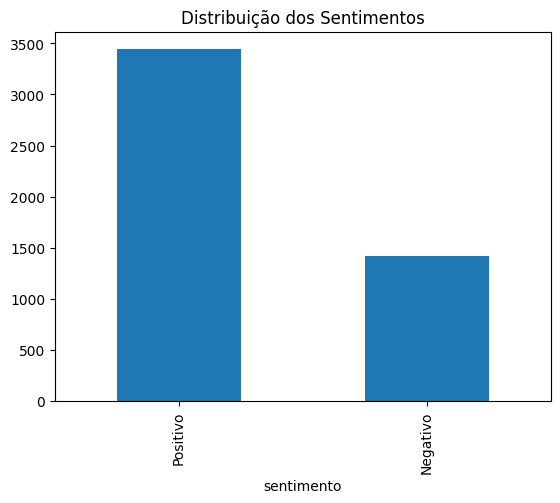

In [ ]:
df['sentimento'].value_counts().plot(kind='bar')
plt.title("Distribuição dos Sentimentos")
plt.show()


Dataset levemente desbalanceado

Ainda aceitável para Logistic Regression

Poderia ser balanceado no futuro (SMOTE, class_weight)

# 🧼 7. Pré-processamento de Texto

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_pt = stopwords.words('portuguese')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zà-ú\s]', '', texto)
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stopwords_pt]
    return ' '.join(palavras)

df['texto_processado'] = df['texto'].apply(limpar_texto)


O texto foi normalizado:
- letras minúsculas
- remoção de pontuação
- remoção de stopwords


# 🔢 8. Vetorização com TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['texto_processado'])
y = df['sentimento']


# 9. Treino e Teste

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 🤖 10. Treinamento do Modelo

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


LogisticRegression(max_iter=1000)